# Import of useful libraries

In [1]:
import networkx as nx # network library
import math # math functions
import numpy as np # linear algebra
import pandas as pd # data processing, CSV/Excel files I/O
import matplotlib.pyplot as plt # data and graph visualization
import random # random distributions
import os # system
import bisect # to take the index of a threshold
from scipy.stats import norm # normal distribution
import time

verbose = False

# Import of data for age and death probabilities

In [9]:
age = pd.read_csv('data/FOLK1A.csv', delimiter = ";", header=[0]) # Take the entire database
n_males = age.INDHOLD.sum() # Count the number of males 
age["prob"] = age.apply(lambda row: row.INDHOLD / n_males, axis=1) # Compute the probability/frequency of each cohort

a = age["prob"].values # probability/frequency vector
b = age.index.values # value associated to each probability


# Take the entire database
data = pd.read_csv('data/lifeTable.csv', header=[0])
# Select Denmark's life table for males
Dk_data = data[["Denmark_Male"]].copy()

# Compute the probability of death
Dk_data["n_death"] = Dk_data["Denmark_Male"] - Dk_data["Denmark_Male"].shift(-1)
Dk_data["n_death"].iloc[-1] = Dk_data["Denmark_Male"].iloc[-1]
Dk_data["p_death"] = Dk_data.apply(lambda row: row.n_death / row.Denmark_Male, axis=1)

# Probability of giving birth - data Denmark 2021
birth_rate = pd.read_excel('data/birth_rate.xlsx', header=[0], index_col = 0)["Prob"]/2

C:\Users\kingo\AppData\Local\Temp\ipykernel_22452\2455054928.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Dk_data["n_death"].iloc[-1] = Dk_data["Denmark_Male"].iloc[-1]


# Network Class

In [10]:
class Network_pop:

  def __init__(self, typeOfNetwork = "ScaleFree", nPop = 1000, M = 2):
    """
    An instance of the class Network_pop
    str typeOfNetwork: can be either Random, Scale-Free, Watts-Strogatz
    int nPop: number of individuals in the network population
    int m: average number of starting neighbors
    """
    if verbose:
      print("The network population has been created")

    # variables and lists of the simulation    
    self.time = 0
    self.popCountList = []
    self.sizeCountList = []
    self.GCCountList = []

    self.nNodes = nPop
    self.M = M

    self.typeOfNetwork = typeOfNetwork
    # choice of network type
    if typeOfNetwork == "ScaleFree":
      self.G = nx.barabasi_albert_graph(n = nPop, m = M)

    if typeOfNetwork == "WattsStrogatz":
      k = round(M/nPop)
      self.G = nx.watts_strogatz_graph( n = nPop, k = k, p = 0)

    if typeOfNetwork == "Random":
      self.G = nx.gnm_random_graph(n = nPop, m = M*nPop, seed=None, directed=False)

  def setParameters(self, death_rate = 0.025, age_dist = 0, cascade = False, cascade_control_parameter = 0.5, 
                    repair = False, repair_rate = 0.3, regeneration = False, birth_rate =  0.025):
    pass


    self.death_rate = death_rate

    if type(age_dist) == int:
      for node in self.G.nodes():
        self.G.nodes[node]["age"] = age_dist
    else:
      for node in self.G.nodes():
        self.G.nodes[node]["age"] = np.random.choice( age_dist.index.values, p = age_dist.values) # assign age to each node

    self.cascade = cascade
    self.cascade_control_parameter = cascade_control_parameter

    if self.cascade:
      for node in self.G.nodes():
        self.G.nodes[node]["initial_neighbors"] = len(list(self.G.neighbors(node))) # save the initial number of neighbors
 
    self.repair = repair
    if repair:
      for edge in self.G.edges:
        age0 = self.G.nodes[edge[0]]["age"]
        age1 = self.G.nodes[edge[1]]["age"]
        self.G.edges[edge]["link_age"] = edgeAge = random.randint(0, age0) if age1 > age0 else random.randint(0, age1)
      if type(repair_rate) == float: # constant exchange rate of the links
        self.repair_rate = repair_rate

    self.regeneration = regeneration
    self.birth_rate = birth_rate


  def simulation(self, numberOfCycles = 90):
    """
    int numberOfCycles: number of runs
    """

    # for the counter
    self.completed = 0
    self.nCycles = numberOfCycles
    self.step = ( self.nCycles // 10 ) * 2
    self.number_of_steps = self.nCycles // self.step

    for i in range(self.nCycles):

      if self.repair: # it has to be before the deaths, because it uses data from previous cycle
        self.link_change()

      if self.regeneration:
        self.new_nodes()

      # choice of the death rate: age-based distribution or fixed?
      if type(self.death_rate) == float:
        self.fixedCycle()
      else:
        self.ageDistCycle()

      if self.cascade:
        self.cascading()

      self.updateCycle()

  def link_change(self):
    """
    Unintentional repair happening through the micro-mechanism of link change
    """
    nodes_changing_link = []
    linksBeforeChange = self.G.number_of_edges()
    for edge in self.G.edges():
      link_age = self.G.edges[edge]["link_age"] # take the age of the connection
      p_d_l = random.uniform(0,1) # pick a scalar from uniform probability distribution
      link_death_p = np.exp(-self.repair_rate*link_age)*0.66 # compute the death probability of the edge
      if p_d_l <= link_death_p:
        nodes_changing_link.append(edge) # add the edge to the list of dead edges
      else:
        self.G.edges[edge]["link_age"] += 1

    if nodes_changing_link:
      unpaired_nodes_changing_link = list(zip(*nodes_changing_link)) # unzip the couples into two vectors
      unpaired_array0 = np.array(unpaired_nodes_changing_link[0]) # select the first array
      unpaired_array1 = np.array(unpaired_nodes_changing_link[1])
      np.random.shuffle(unpaired_array0) # shuffle the first array
      np.random.shuffle(unpaired_array1)
      new_edges = list(zip(unpaired_array0, unpaired_array1)) # create the new list of edges

      self.G.remove_edges_from(nodes_changing_link)
      self.G.add_edges_from(new_edges, link_age=1)

    if len(self.sizeCountList) > 1:
      if self.G.number_of_edges() < linksBeforeChange: # if the number of edges has diminished
        random_edges = list(np.random.choice(self.G.nodes,(linksBeforeChange - self.G.number_of_edges(),2))) # create random couples -is this ok also for SF nets?
        self.G.add_edges_from(random_edges, link_age=1) # add random couples as new edges to the network

  def new_nodes(self):

    local_network = self.G.copy() # make a local copy of the network
    list_nodes = list(local_network.nodes()) # put the nodes in a list
    random.shuffle(list_nodes) # randomize the list, this way the order will be different at every cycle

    for node in list_nodes:
      p_b = random.uniform(0,1)
      node_age = local_network.nodes[node]["age"]
      if p_b <= self.birth_rate.iloc[node_age]:
        self.nNodes += 1
        self.G.add_node(self.nNodes, age = 0) # creating the node
        
        if self.typeOfNetwork == "Random": # random attachment
          for i in range(self.M):
            random_node = random.choice(list(self.G.nodes()))
            self.G.add_edge(node, self.nNodes, link_age = 0) # connecting the node and another random node

        if self.typeOfNetwork == "ScaleFree": # copying model, ignorance of the new node
          if list(self.G.neighbors(node)): # if there are neighbors
            new_neighbors = random.choices(list(self.G.neighbors(node)), k = self.M-1)
          else:
            new_neighbors = random.choices(list(self.G.nodes()), k = self.M-1)
          for i in new_neighbors:
            self.G.add_edge(self.nNodes, i, link_age = 0) # connecting the node with a link of the parent

        self.G.add_edge(node, self.nNodes, link_age = 0) # connecting the node and the parent
        self.G.nodes[self.nNodes]["initial_neighbors"] = len(list(self.G.neighbors(self.nNodes))) # save the initial number of neighbors

  def cascading(self):
    cascade_network = self.G.copy()
    cascade_list_nodes = list(cascade_network.nodes())
    random.shuffle(cascade_list_nodes)

    for node in cascade_list_nodes:
        if len(list(self.G.neighbors(node))) < self.G.nodes[node]["initial_neighbors"]*self.cascade_control_parameter:
          self.G.remove_node(node)

  def fixedCycle(self):
    """
    The number of removed nodes will be a fixed percentage of the alive ones
    """
    n_removals = round(self.G.number_of_nodes()*self.death_rate)
    removable_nodes = random.sample(list(self.G.nodes()), n_removals)
    self.G.remove_nodes_from(removable_nodes)

  def ageDistCycle(self):
    local_network = self.G.copy() # make a local copy of the network
    list_nodes = list(local_network.nodes()) # put the nodes in a list
    random.shuffle(list_nodes) # randomize the list, this way the order will be different at every cycle

    for node in list_nodes:
        p_d = random.uniform(0,1)
        node_age = local_network.nodes[node]["age"]
        if p_d <= self.death_rate.iloc[node_age]: 
            self.G.remove_node(node)
        else:
            self.G.nodes[node]["age"] += 1


  def updateCycle(self):

    # update the lists
    Gcc = sorted(nx.connected_components(self.G), key=len, reverse=True)
    if Gcc:
        Ggc = self.G.subgraph(Gcc[0])
        self.GCCountList.append(Ggc.number_of_nodes())
    else:
        self.GCCountList.append(0)

    if self.G.size(): 
      self.sizeCountList.append(self.G.size())
    else:
      self.sizeCountList.append(0)
    if self.G.number_of_nodes():
      self.popCountList.append(self.G.number_of_nodes())
    else:
      self.popCountList.append(0)

    # update the status of the simulation
    if self.time % self.step == 0:
      if self.time == 0 and verbose: 
        print("Simulation started")
      if verbose:
        print("\t\t["+ " * "*self.completed +  " - "*(self.number_of_steps-self.completed) +"]")
      self.completed += 1
    if self.time + 1 == self.nCycles:
      if verbose:
        print("\t\t["+ " * "*(self.completed) +"]")
        print("Simulation completed.")

    # tickm update the clock
    self.time += 1

# Simulation and visualization Function

In [11]:
def mortality_rate(x):
  return np.array([ -(x[i+1]-x[i])/x[i] for i in range(len(x)-1) if (x[i]> 0 and x[i+1]>=0)])

In [12]:
def simvis(nSim, typeOfNetwork, nPop, M, death_rate, age_dist, numberOfCycles, cascade = False, 
           cascade_control_parameter = 0.5, repair = False, regeneration = False, birth_rate = 0,
           saveimg = False):
  """
  int nSim: number of simulations
  str typeOfNetwork: defines the typology of the network and can be either Random, Scale-Free, Watts-Strogatz
  int nPop: number of individuals in the network population
  int M: number of links (if SF is the number of new links for each node, otherwise total number of links)
  float death_rate: variable used if a fixed death rate is needed, otherwise it is a probability vector distribution
  list age_dist: probability vector distribution of ages in a certain population
  int numberOfCycles: number of runs of each simulation
  int threshold: population under which the network could be considered dissolved
  """

  popCountListList = [] # list of lists of node counts
  sizeCountListList = [] # list of lists of size counts
  GCCountListList = [] # list of lists of node in Giant Component counts
  mus_n = [] # list of mortality rate vector distributions of the entire network population
  mus_gc = [] # list of mortality rate vector distributions of the Giant Component
  collapses = [] # list of moments of collapse of the Giant Component

  fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2,3, figsize=(20, 10))

  for n in range(nSim):
    net = Network_pop(typeOfNetwork = typeOfNetwork, nPop = nPop, M = M)
    net.setParameters(death_rate = death_rate, age_dist = age_dist, cascade = cascade, 
                      cascade_control_parameter = cascade_control_parameter, repair = repair,
                      regeneration = regeneration, birth_rate = birth_rate)
    net.simulation(numberOfCycles = numberOfCycles)

    popCountListList.append(net.popCountList)
    sizeCountListList.append(net.sizeCountList)
    GCCountListList.append(net.GCCountList)

    ax1.plot(net.sizeCountList, color = "gray", alpha = 0.5)
    ax2.plot(net.popCountList, color = "gray", alpha = 0.5)
    ax3.plot(net.GCCountList, color = "gray", alpha = 0.5)

    mu_n = mortality_rate(net.popCountList)
    mu_n[mu_n == 0] = np.nan
    mus_n.append(mu_n)
    mu_gc = mortality_rate(net.GCCountList)
    mu_gc[mu_gc == 0] = np.nan
    mus_gc.append(mu_gc)
    ax4.plot(mu_n, color = "gray", alpha = 0.5)
    ax4.plot(mu_gc, color = "yellow", alpha = 0.5)

    ax5.plot(mu_n, color = "gray", alpha = 0.5)
    ax5.plot(mu_gc, color = "yellow", alpha = 0.5)


  popsmean = np.mean(popCountListList, axis=0)
  sizesmean = np.mean(sizeCountListList, axis=0)
  GCsmean = np.mean(GCCountListList, axis=0)
  GCsstd = np.std(GCCountListList, axis=0)

  mu_n_mean = np.nanmean(mus_n, axis=0)
  mu_gc_mean = np.nanmean(mus_gc, axis=0)

  ax1.plot(sizesmean, color = "blue", alpha = 1 )
  ax1.set_xlabel('time')
  ax1.set_ylabel("Size")

  ax2.plot(popsmean, color = "blue", alpha = 1, label ="Network" )
  ax2.plot(GCsmean, color = "red", alpha = 1, label = "Giant Component" )
  ax2.set_xlabel('time')
  ax2.set_ylabel("Nodes")
  ax2.legend(loc="upper right")

  ax3.plot(GCsmean, color = "red", alpha = 1 )
  ax3.set_xlabel('time')
  ax3.set_ylabel("Nodes in the GC")


  maxstd = np.argmax(GCsstd) # select the point where std is max
  threshold = GCsmean[maxstd]
  #threshold_value = net.nCycles-bisect.bisect(GCsmean[::-1], threshold)
  ax3.axvline(maxstd, color = "blue") 
  ax3.text(maxstd, -.05, maxstd, color='blue', transform=ax3.get_xaxis_transform(), ha='center', va='top')
  ax3.axhline(y=threshold, color='green', alpha = 0.8, linestyle='-')
  ax3.text( -9, threshold, threshold, color='green', ha='center', va='center')

  ax4.plot(mu_n_mean, label = "Network", color = "blue", alpha = 1)
  ax4.plot(mu_gc_mean, label = "Giant Component", color = "red", alpha = 1)
  ax4.legend(loc="upper left")
  ax4.set_yscale("log")
  ax4.set_xlabel('time')
  ax4.set_ylabel("Log Mortality Rate")

  ax5.plot(mu_n_mean, label = "Network", color = "blue", alpha = 1)
  ax5.plot(mu_gc_mean, label = "Giant Component", color = "red", alpha = 1)
  ax5.set_xlabel('time')
  ax5.set_ylabel("Mortality Rate")
  ax5.legend(loc="upper left")

  collapses = [net.nCycles-bisect.bisect(i_list[::-1], threshold) for i_list in GCCountListList ]
  mean, std = norm.fit(collapses)
  ax6.hist(collapses, density = True)
  ax6.set_xlabel('time')
  ax6.set_ylabel("Frequency")
  xmin, xmax = plt.xlim()
  x = np.linspace(xmin, xmax, 100)
  p = norm.pdf(x, mean, std)
  ax6.plot(x, p, 'k', linewidth=2)

  aget = age_dist if type(age_dist) == int else "age_dist"
  drivepath = "/content/drive/MyDrive/Colab Notebooks/MasterThesis"
  filename = "{0}&nPop={1}&M={2}&death_rate={3}&age_dist={4}&nCycles={5}&nSim={6}&cascade={7}&repair={8}&birth={9}.png".format(typeOfNetwork, nPop, M, isinstance(death_rate, float), aget, numberOfCycles, nSim, cascade, repair, regeneration )
  fig.suptitle(filename)
  if saveimg:
    plt.savefig(os.path.join(drivepath, filename))
  plt.show()

  return popCountListList, sizeCountListList, GCCountListList, mus_n, mus_gc

## Random Net

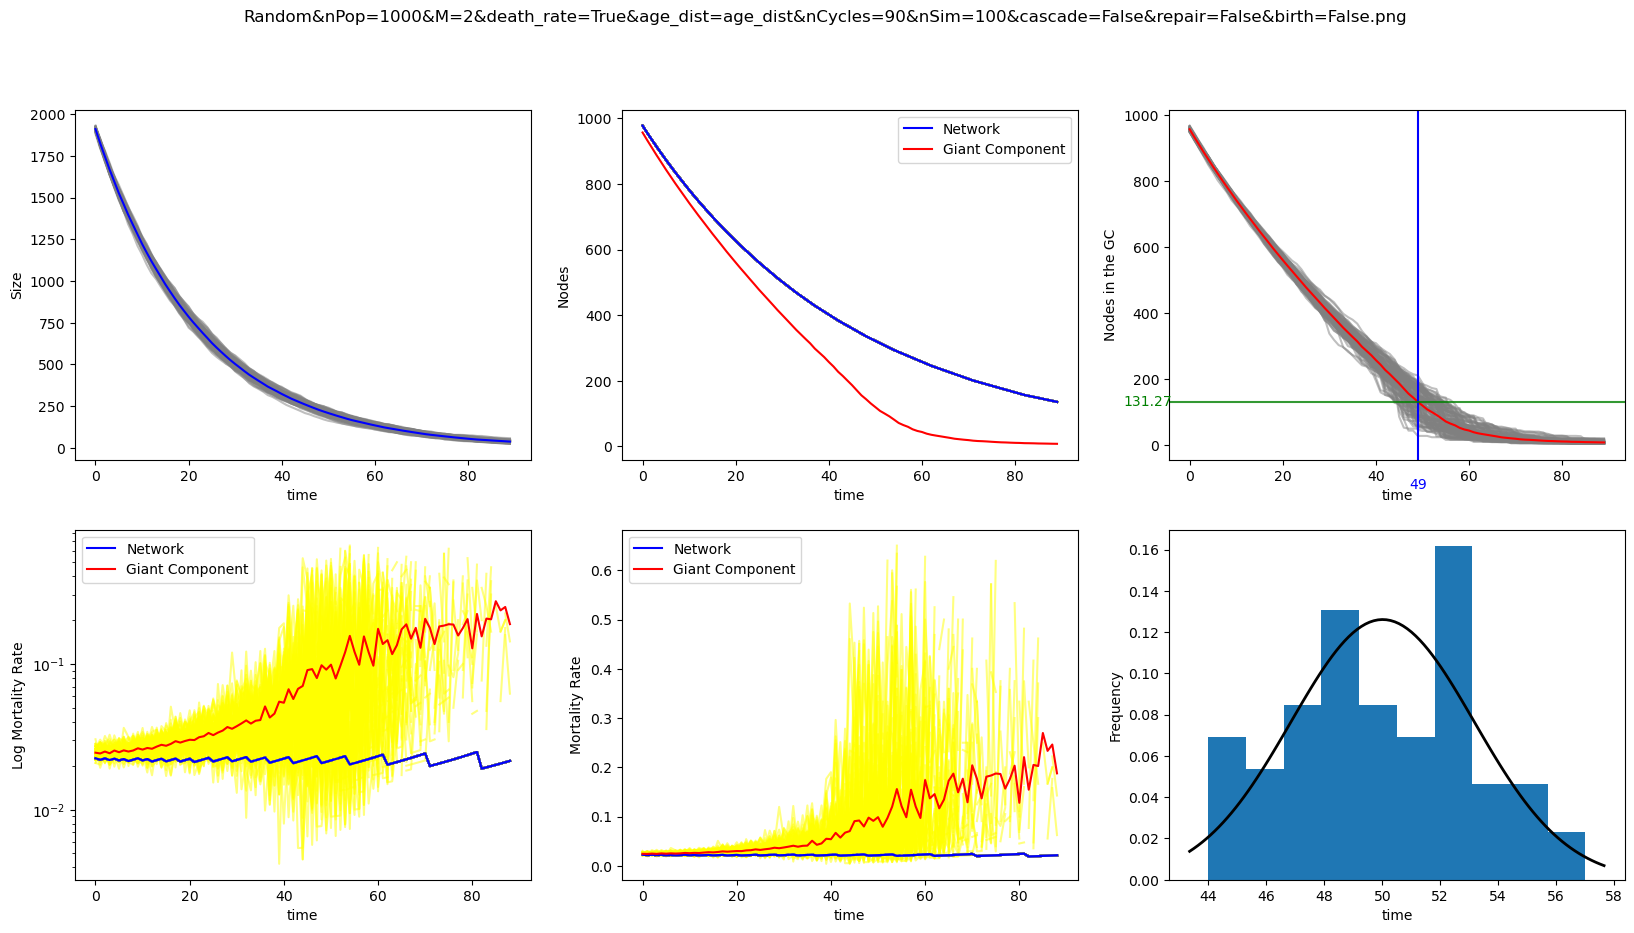

In [15]:
randomResults = simvis(nSim = 100, typeOfNetwork = "Random", nPop = 1000, M = 2, death_rate = 0.022, age_dist = age["prob"], numberOfCycles = 90, repair = False)

## Scale-Free Net

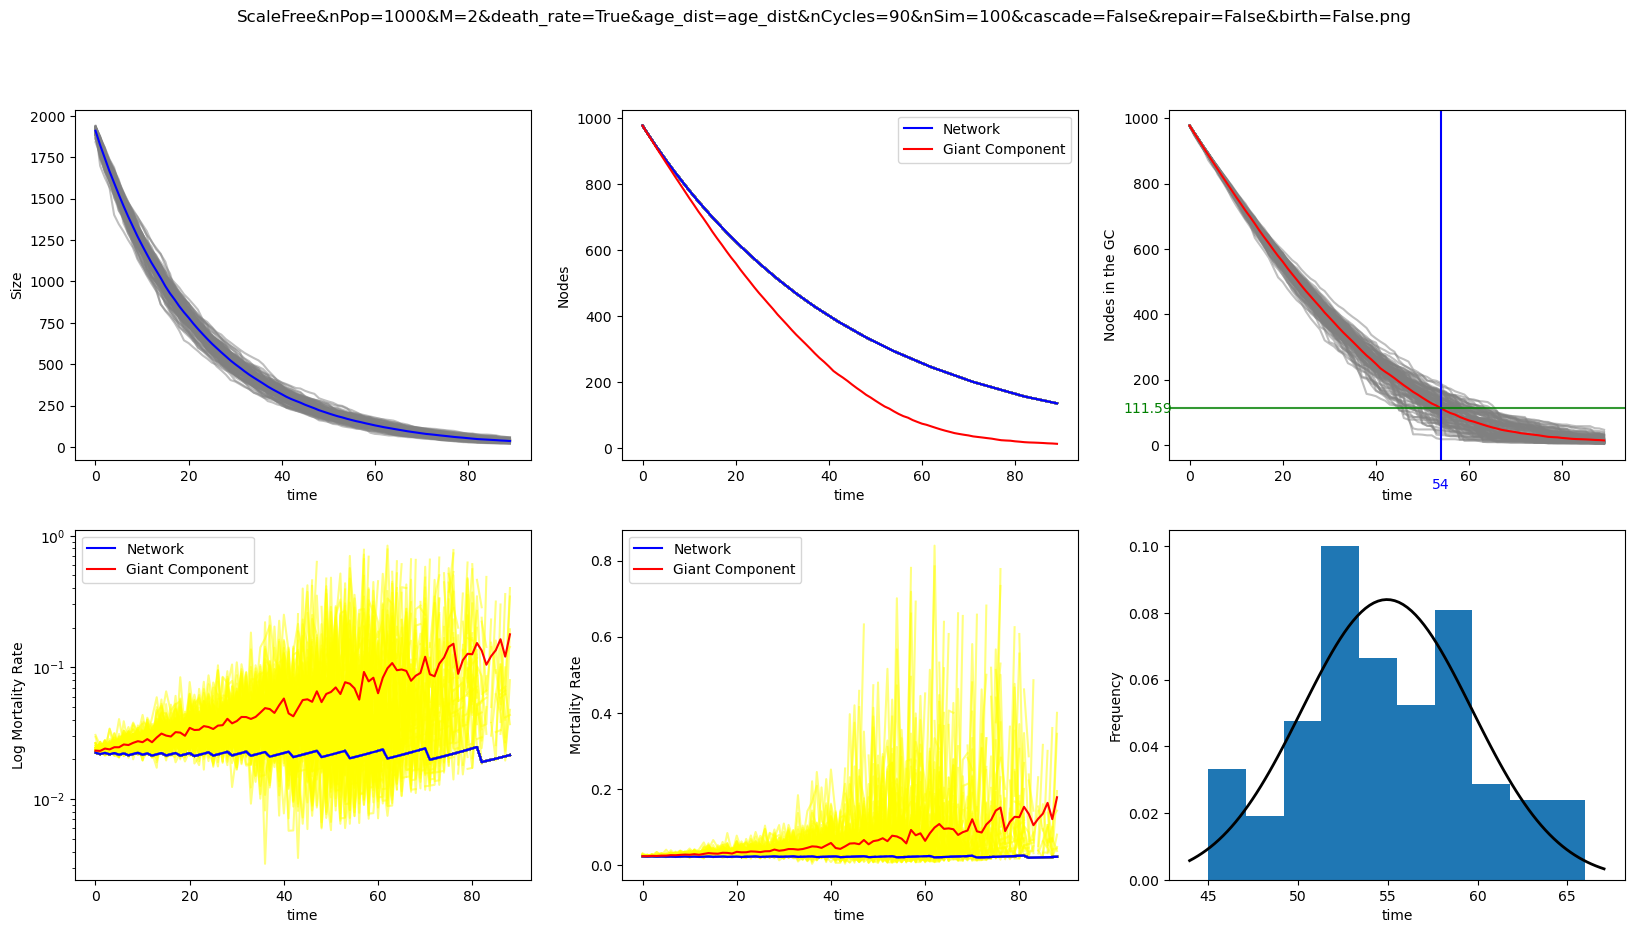

In [17]:
ScaleFreeResults = simvis(nSim = 100, typeOfNetwork = "ScaleFree", nPop = 1000, M = 2, death_rate = 0.022, age_dist = age["prob"], numberOfCycles = 90, repair = False)

C:\Users\kingo\AppData\Local\Temp\ipykernel_22452\525639504.py:57: RuntimeWarning: Mean of empty slice
  mu_n_mean = np.nanmean(mus_n, axis=0)
C:\Users\kingo\AppData\Local\Temp\ipykernel_22452\525639504.py:58: RuntimeWarning: Mean of empty slice
  mu_gc_mean = np.nanmean(mus_gc, axis=0)


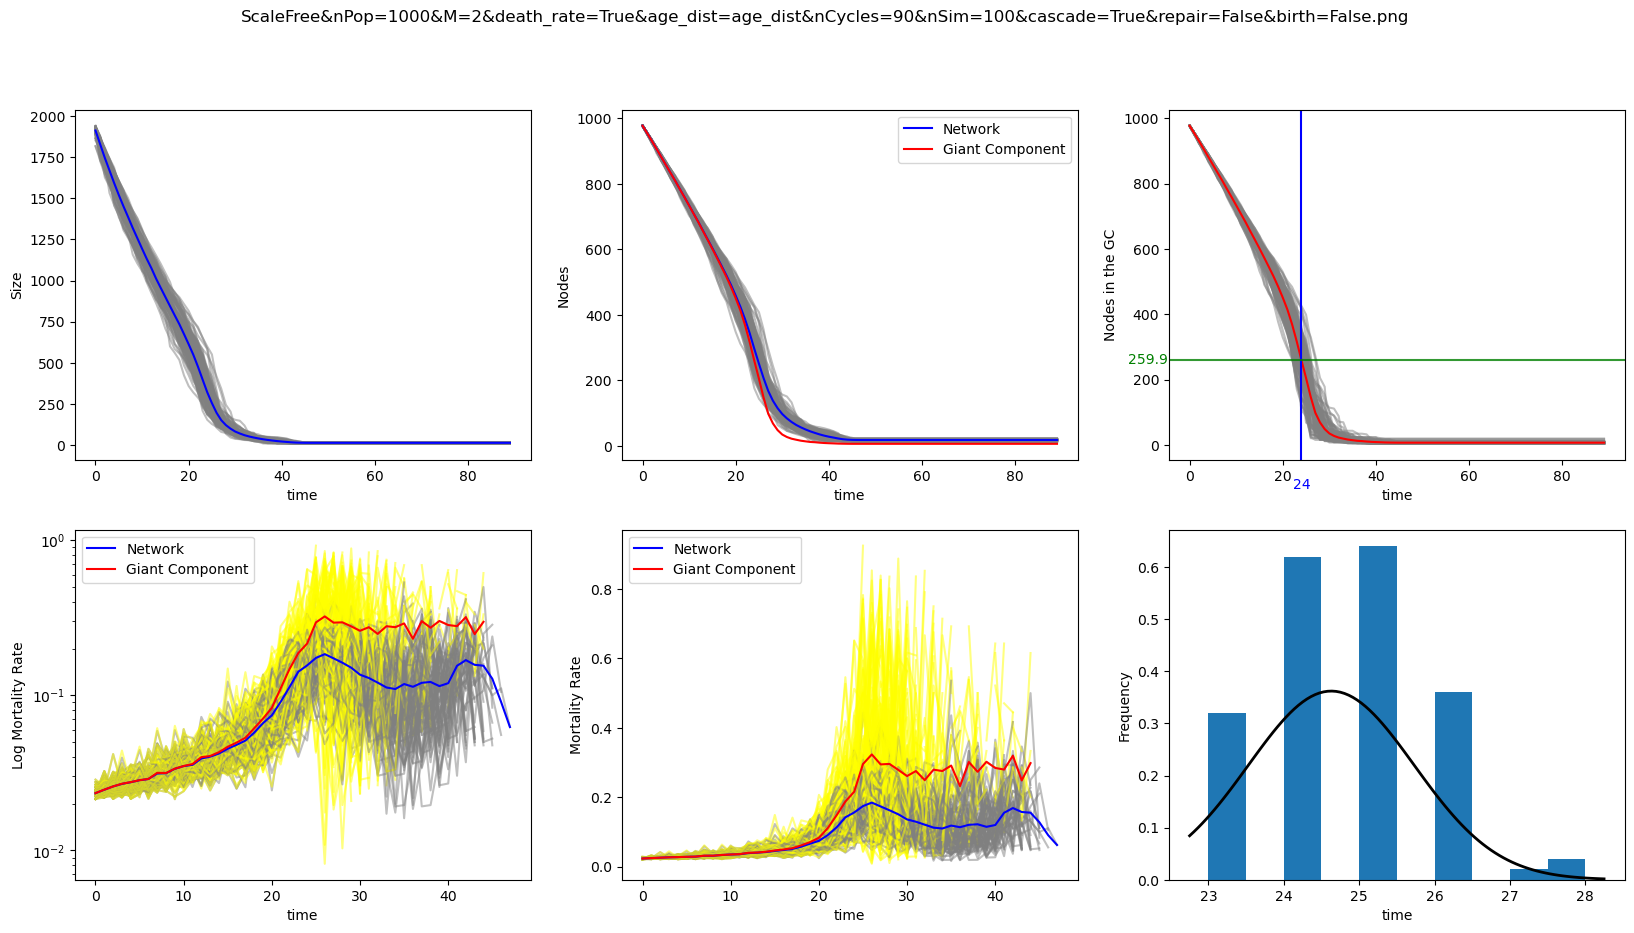

In [19]:
ScaleFreeResultsCascade = simvis(nSim = 100, typeOfNetwork = "ScaleFree", nPop = 1000, M = 2, death_rate = 0.022, age_dist = age["prob"], numberOfCycles = 90, cascade = True)

C:\Users\kingo\AppData\Local\Temp\ipykernel_22452\525639504.py:57: RuntimeWarning: Mean of empty slice
  mu_n_mean = np.nanmean(mus_n, axis=0)
C:\Users\kingo\AppData\Local\Temp\ipykernel_22452\525639504.py:58: RuntimeWarning: Mean of empty slice
  mu_gc_mean = np.nanmean(mus_gc, axis=0)


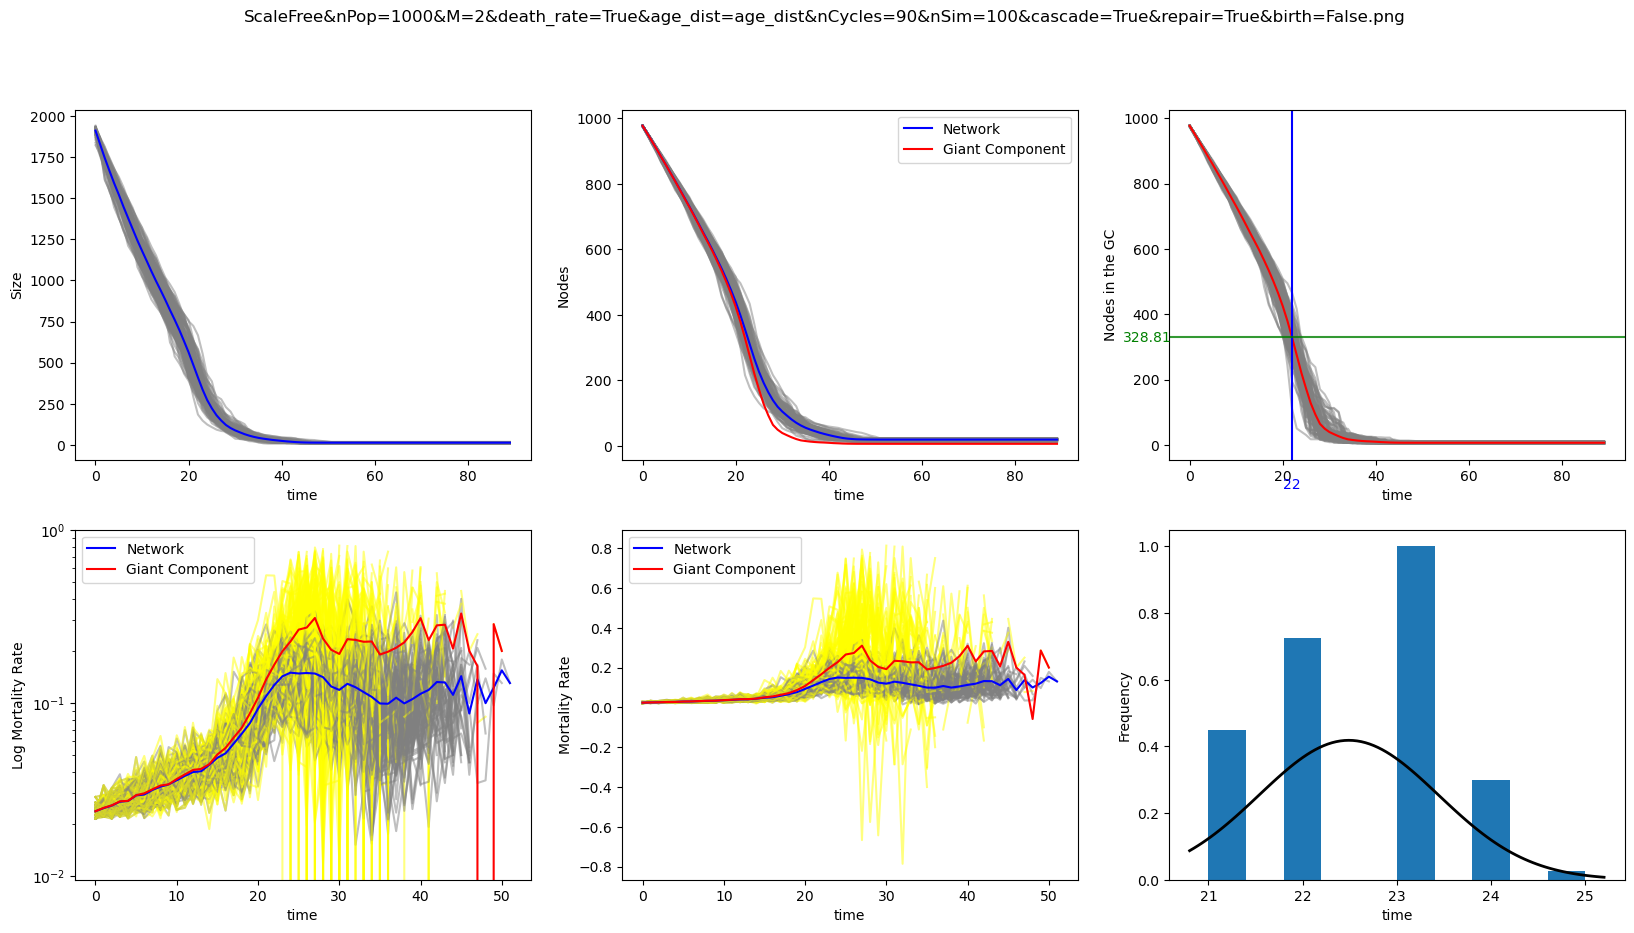

In [20]:
ScaleFreeResultsCascadeRepair = simvis(nSim = 100, typeOfNetwork = "ScaleFree", nPop = 1000, M = 2, death_rate = 0.022, age_dist = age["prob"], numberOfCycles = 90, cascade = True, repair = True)

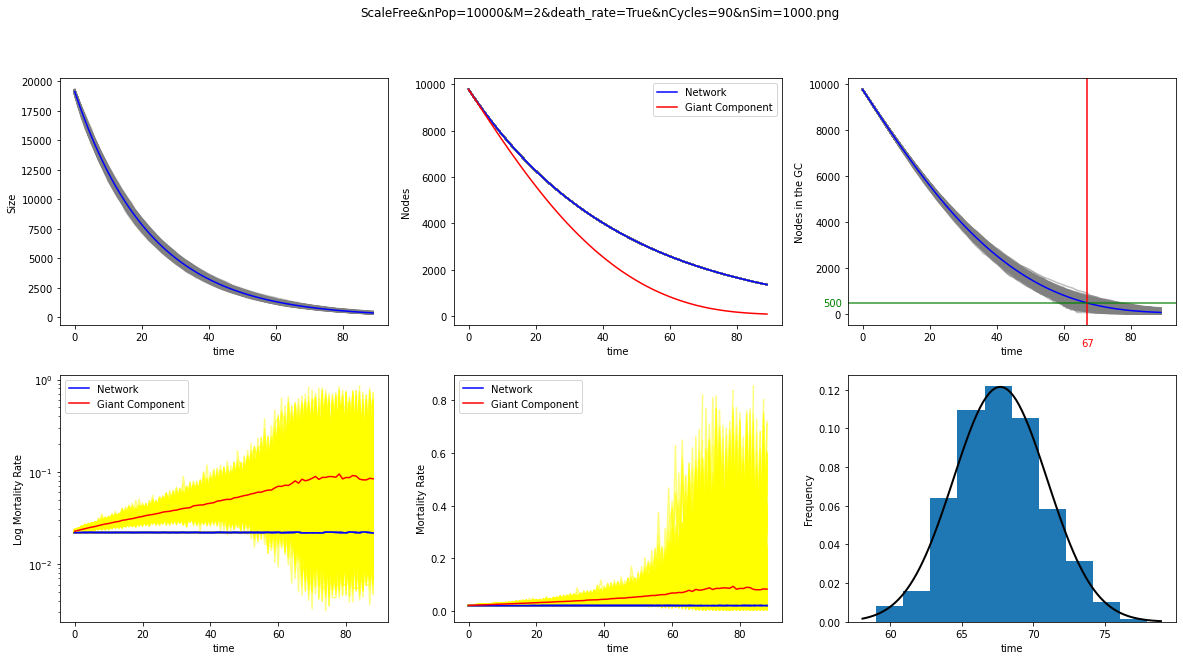

In [ ]:
ScaleFreeResults = simvis(nSim = 1000, typeOfNetwork = "ScaleFree", nPop = 10000, M = 2, death_rate = 0.022, age_dist = age["prob"], numberOfCycles = 90, threshold = 500)

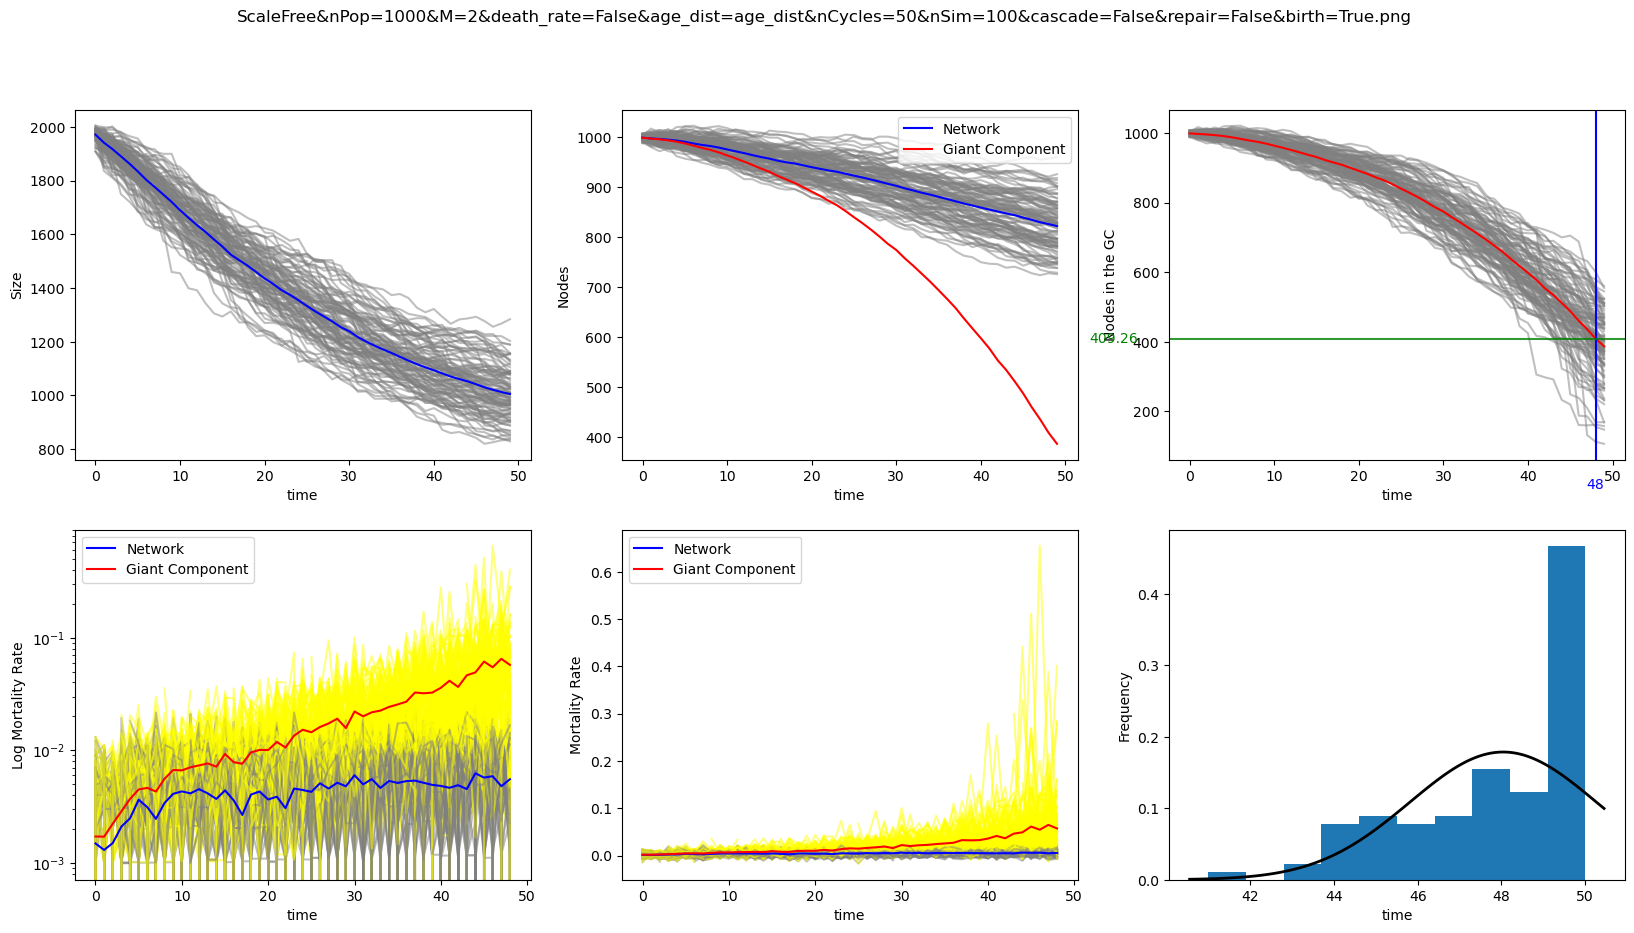

In [21]:
ScaleFreeResults = simvis(nSim = 100, typeOfNetwork = "ScaleFree", nPop = 1000, M = 2, death_rate = Dk_data["p_death"], 
                          age_dist = age["prob"], numberOfCycles = 50, regeneration = True, birth_rate = birth_rate, 
                          repair = False, cascade = False,
                          saveimg = False)

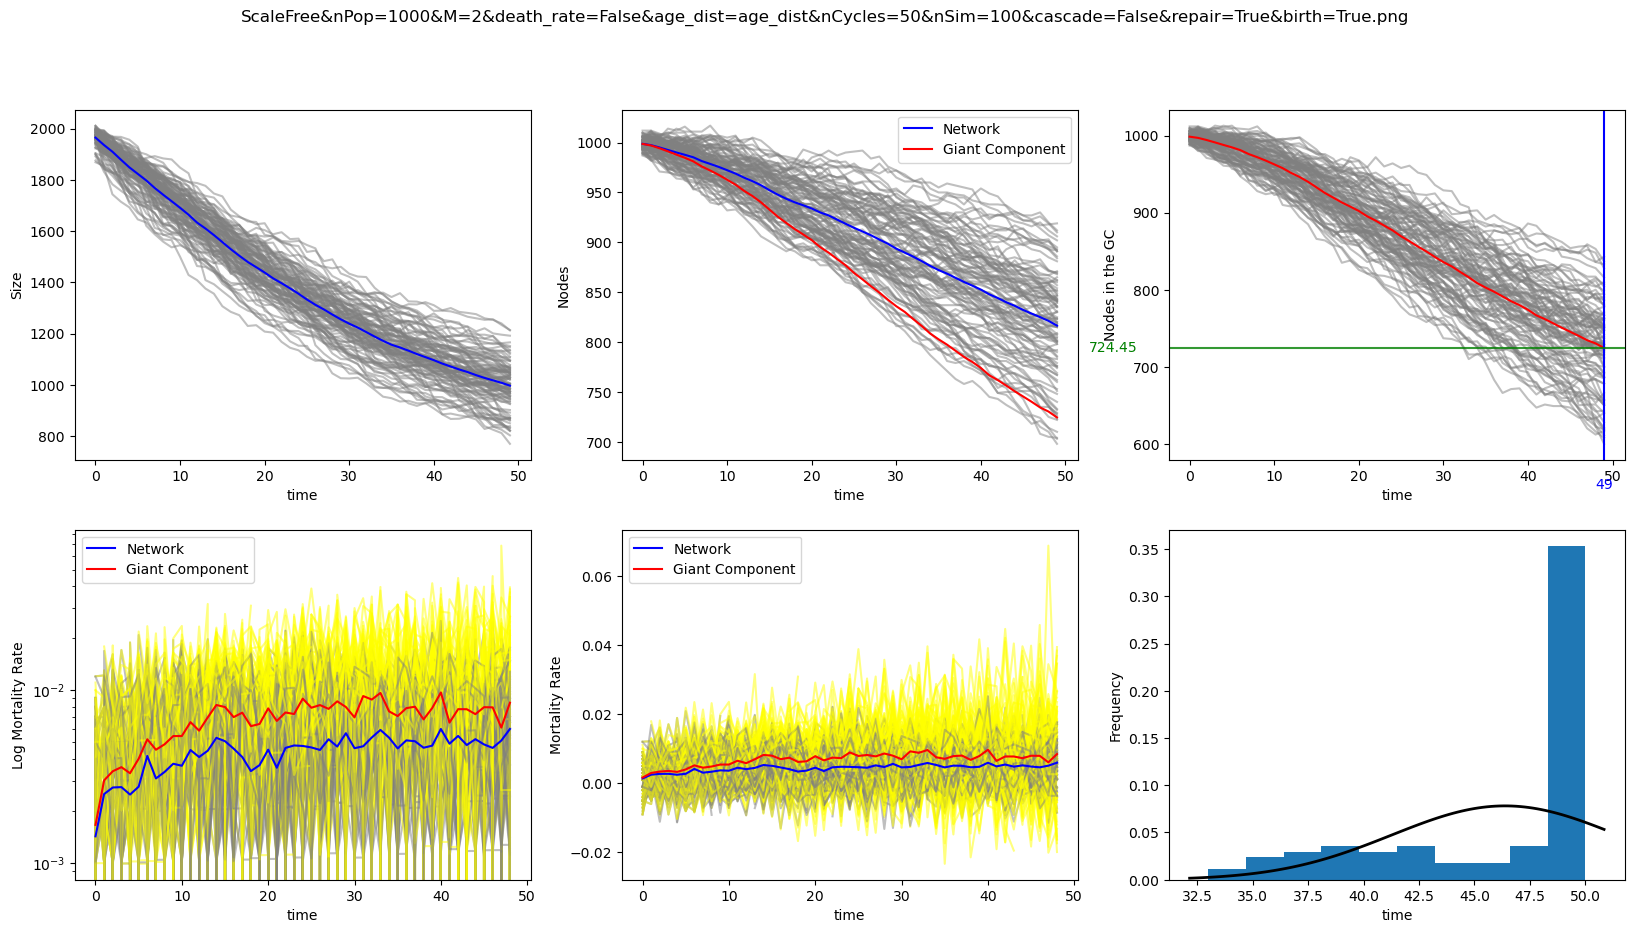

In [22]:
ScaleFreeResults = simvis(nSim = 100, typeOfNetwork = "ScaleFree", nPop = 1000, M = 2, death_rate = Dk_data["p_death"], 
                          age_dist = age["prob"], numberOfCycles = 50, regeneration = True, birth_rate = birth_rate, 
                          repair = True, cascade = False,
                          saveimg = False)

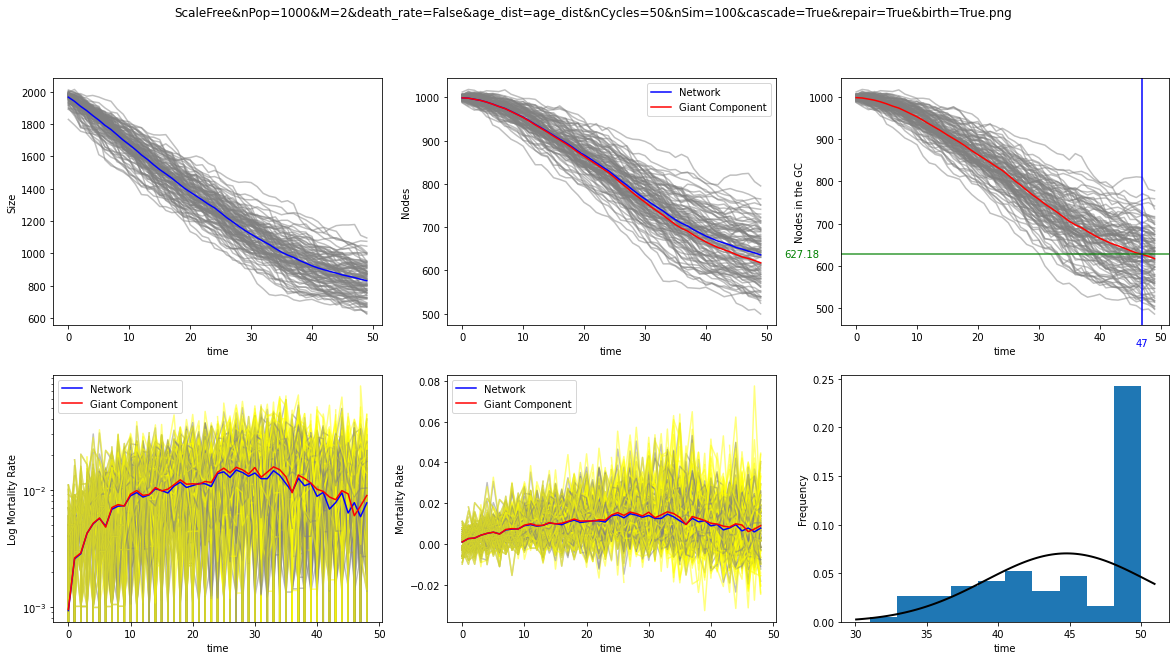

-318.00392484664917


In [ ]:
start = time.time()
ScaleFreeResults = simvis(nSim = 100, typeOfNetwork = "ScaleFree", nPop = 1000, M = 2, death_rate = Dk_data["p_death"], 
                          age_dist = age["prob"], numberOfCycles = 50, regeneration = True, birth_rate = birth_rate, 
                          repair = True, cascade = True,
                          saveimg = False)
end = time.time()
print(start-end)

50


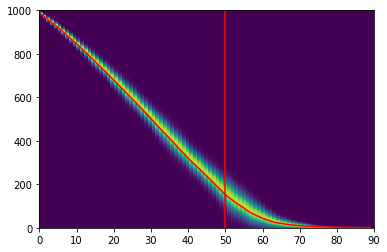

In [ ]:
GCsmean = np.mean(ScaleFreeResults[2], axis=0)
GCsstd = np.std(ScaleFreeResults[2], axis=0)

Xspace = np.linspace(0,90,90)
Yspace = np.linspace(0,1000,5000)
X,Y = np.meshgrid(Xspace,Yspace)

Zoc = [(np.exp(- np.square(Yspace - GCsmean[i]) / (2*np.square(GCsstd[i]) )) / np.sqrt((2*math.pi)*GCsstd[i]**0.05)  ) for i in range(90)]

maxstd = np.argmax(GCsstd)
print(maxstd)
plt.axvline(maxstd, color = "red")

# Plot the density map using nearest-neighbor interpolation
plt.pcolormesh(X,Y,np.array(Zoc).T)
plt.plot(GCsmean, color = "r")
plt.show()

In [ ]:
sfResults = simvis(nSim = 100, typeOfNetwork = "ScaleFree", nPop = 50000, M = 2, death_rate = 0.02, age_dist = age["prob"], numberOfCycles = 90, repair = True, cascade = True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: Mean of empty slice
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: Mean of empty slice
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: MatplotlibDeprecationWarning: Unrecognized location 'bottom right'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.
  del sys.path[0]


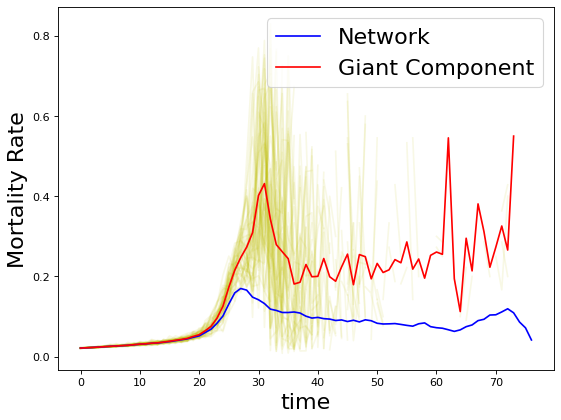

In [16]:
popCountListList, sizeCountListList, GCCountListList, mus_n, mus_gc = sfResults
